### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

### Dataframe

In [18]:
dataframe = pd.read_csv("/Datasets/IntelData.csv")
experimentalDF = dataframe[['Week','Customer Orders','Forecasted Demand']].copy(deep=True)
allCOs = experimentalDF.groupby('Week')['Customer Orders'].mean()
allForecasts = experimentalDF.groupby('Week')['Forecasted Demand'].mean()
experimentalDF = allCOs.to_frame(name='COs')
experimentalDF['Forecasts'] = allForecasts
# experimentalDF

### Generating the lags

In [19]:
experimentalDF['yK-1'] = experimentalDF['COs'].shift(1)
experimentalDF['yK-2'] = experimentalDF['COs'].shift(2)
# experimentalDF

### Establishing a validation set

In [20]:
validationSet = experimentalDF.tail(10)
# validationSet

### Discarding validation rows from the training set.

In [21]:
experimentalDF = experimentalDF.iloc[:-10 , :]
# experimentalDF

### Drop NaNs which occur due to the lag

In [22]:
experimentalDF = experimentalDF.dropna()
# experimentalDF

### Generating the training feature matrix

In [23]:
X_mat = np.empty((len(experimentalDF),3),dtype =float)
X_mat[:,0] = 1
X_mat[:,1] = experimentalDF['yK-1']
X_mat[:,2] = experimentalDF['yK-2']
# X_mat.shape

### Generating validation feature matrix

In [24]:
V_mat = np.empty((len(validationSet),3),dtype =float)
V_mat[:,0] = 1
V_mat[:,1] = validationSet['yK-1']
V_mat[:,2] = validationSet['yK-2']
# V_mat.shape

### Plotting for both training and validation.

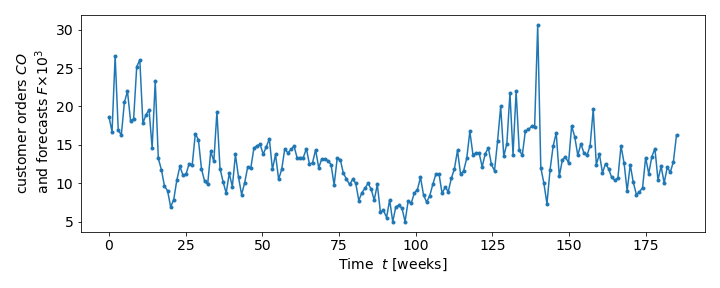

In [38]:
plt.rcParams['font.size'] = 14
plt.close('all')
fig,ax = plt.subplots(figsize=(10,4))

y1 = pd.concat([experimentalDF.COs, validationSet.COs])
x1 = np.linspace(0,len(y1),len(y1))
ax.plot(x1,y1/1e3,marker=".") 
ax.set(xlabel="Time  $t$ [weeks]", ylabel="customer orders $CO$\n and forecasts $F$$\\times 10^3$")
# fig.supxlabel('Time in Weeks')
# fig.supylabel('Customer Orders')

fig.tight_layout()

### LinearRegression model training fit.

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_mat, experimentalDF.COs.values)
yhat1 = model.predict(X_mat)
plotX1 = np.linspace(0,len(experimentalDF.COs),len(experimentalDF.COs))
ax.plot(plotX1,yhat1,label="Predictions")
ax.legend()

### Validation predictions

In [27]:
plotX2 = np.linspace(175,185,10)
yhat2 = model.predict(V_mat)
ax.plot(plotX2,yhat2,label="Validation")
ax.legend()

### Training errors

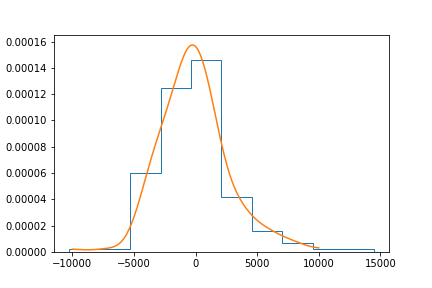

In [12]:
from scipy.stats import gaussian_kde as gkde
num="Training Error Distribution"
if plt.fignum_exists(num):plt.close(num)
figD, axD = plt.subplots(num=num)
axD.hist(experimentalDF.COs-yhat1,density=True,histtype="step")
kernel = gkde(experimentalDF.COs-yhat1)
x = np.linspace(-10_000,10_000,200)
axD.plot(x,kernel(x))

### Appending validation predictions to the validationSet.

In [13]:
np.warnings.filterwarnings('ignore') ### SettingWithCopyWarning
validationSet['yHat'] = yhat2
# validationSet

### Error distribution of validation results.

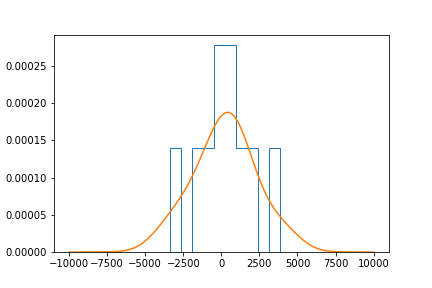

In [14]:
from scipy.stats import gaussian_kde as gkde
num="Error Distribution"
if plt.fignum_exists(num):plt.close(num)
figD, axD = plt.subplots(num=num)
axD.hist(validationSet.COs-validationSet.yHat,density=True,histtype="step")
kernel = gkde(validationSet.COs-validationSet.yHat)
x = np.linspace(-10_000,10_000,200)
axD.plot(x,kernel(x))

### Original demand and forecasts. To compare with LR and validation

Text(0.02, 0.5, 'Customer Orders')

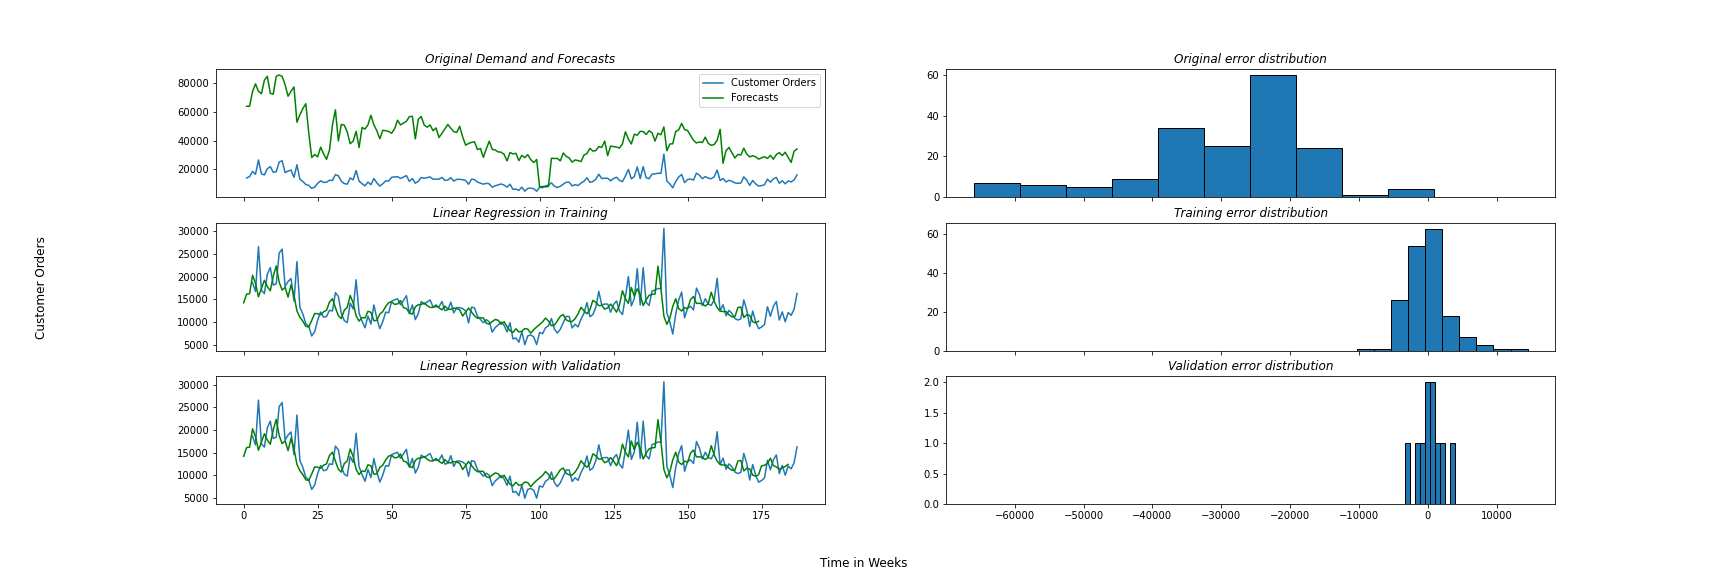

In [16]:
plt.close('all')

num="Comparison plots"
if plt.fignum_exists(num):plt.close(num)
fig,ax = plt.subplots(num=num,nrows= 3, ncols=2,sharex='col',figsize=(24,8))

ax[0,0].plot(allCOs,label="Customer Orders")
ax[0,0].plot(allForecasts, color='g',label = "Forecasts")
ax[0,0].set_title('Original Demand and Forecasts', fontstyle='italic')
ax[0,0].legend()
ax[0,1].hist(experimentalDF.COs.values-experimentalDF.Forecasts.values, edgecolor="black")
ax[0,1].set_title('Original error distribution', fontstyle='italic')

ax[1,0].plot(y1)
ax[1,0].plot(yhat1,color='g')
ax[1,0].set_title('Linear Regression in Training', fontstyle='italic')
ax[1,1].hist(experimentalDF.COs-yhat1, edgecolor="black")
ax[1,1].set_title('Training error distribution', fontstyle='italic')

ax[2,0].plot(y1)
ax[2,0].plot(np.r_[yhat1, yhat2],color='g')
ax[2,0].set_title('Linear Regression with Validation', fontstyle='italic')
ax[2,1].hist(validationSet.COs-yhat2, edgecolor="black")
ax[2,1].set_title('Validation error distribution', fontstyle='italic')


fig.supxlabel('Time in Weeks')
fig.supylabel('Customer Orders')


### Rough Work